In [22]:
%matplotlib inline
# %matplotlib qt

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import arc
import random
import networkx as nx
import time
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.animation as animation
from IPython.display import HTML

In [63]:
#### ##Functions for autogenerating Hamiltonians
###

M=1

op2state = [qeye(2),create(2),destroy(2)]
opOnSite = [qeye(2),sigmaz()]


def getBasisFast(index,n):
    num = 0
    for i in range(2,n+2):
        
        if index%2 == 1:
            num += 1
            index -= 1
        index/=2
        
    return num

def choose(n,k):
    c = 1
    for i in range(k+1,n+1):
        c *= i
    for i in range(2,n-k+1):
        c/=i
    return int(c)

def extractBlock(H,n,val,order,s=None):
    size = choose(n,val)
    indices = []
    tot = 0
    for i in range(2**n):
        if getBasisFast(i,n) == val:
            indices.append(i)
            tot += 1
        if tot == size:
            break
    arr = []
    if s:
        arr = np.take(s,indices)
        q = Qobj(arr,dims=[[2 for i in range(val)],[1 for i in range(val)]], shape=(order,1))
    else:
        for i in indices:
            arr.append(np.take(H[i][0],indices))
        q = Qobj(arr,dims = [[2 for i in range(val)] for i in range(2)], shape = (order, order))
    return q

class Node:
    
    def __init__(self,ind,coord,pairs):
        self.id = ind
        self.coord = coord
        self.pairs = pairs

theta = np.pi/6

def genLadderPair(c,d,size):
    op = tensor([op2state[int(i==c)+int(i==d)*2] for i in range(size)])
    return op

def genOnSite(i,size):
    op = (1/(2**(size)))*tensor([opOnSite[0]+(1-2*int(i==j))*opOnSite[1] for j in range(size)])
    return op

def transform(coord):
    x=coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta))
    y=coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta))
    return x,y

#Generates an adjacency matrix from a list of pairs 
def genAdjMatrix(dim,nodes):
    matrix = np.array([np.zeros(dim,dtype=np.cdouble) for i in range(dim)])
    
    for ind, node in nodes.items():
        if node.pairs:
            n1 = node.id
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])].id
                    if matrix[n1,n2] == 0.+0.j:
                        w = pair[2]
                        matrix[n1,n2] = w
                        matrix[n2,n1] = np.conj(w)
    print(matrix)
    return matrix, nodes

def tess(x,y,wx,wy,wz,a):
    if a:
        return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz],\
            [[x,y,1],[x+1,y,1],0-1j],[[x,y,1],[x,y+1,1],0+1j],[[x,y,1],[x-1,y+1,1],-1j]]
    else:
        return [[[x,y,0],[x+1,y,0],0+1j],[[x,y,0],[x,y+1,0],0-1j],[[x,y,0],[x-1,y+1,0],0+1j]]
#Alternating "on" and "off" starting from edge
def genAdj(dim,wx,wy,wz):
    nodes = {str([0,0,1]):Node(1,[0,0,1],tess(0,0,wx,wy,wz,True))}
    ydim = dim
    xdim=dim

    for y in range(ydim):
#         for x in range(int(-y/2),dim+int((dim-y)/2)):
        for x in range(xdim):
            if not (x==y and y==0):
                if not (x==xdim-1 and y==ydim-1):
                    nodes[str([x,y,1])] = Node((y*xdim+x)*2,[x,y,1],tess(x,y,wx,wy,wz,True))
                nodes[str([x,y,0])] = Node((y*xdim+x)*2+1,[x,y,0],tess(x,y,wx,wy,wz,False))
    nodes[str([ydim-1,xdim-1,0])].id-=1
    for ID,node in nodes.items():
        node.id-=1
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)
    for ID,node in nodes.items():
        print(ID,node.id)
    return nodes
        
#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = (tensor([obs_list[int(i==j)] for j in range(n)]))
    return observables
     
def adj_to_ham(n): #The row/col of an adj matrix corresponds to Hamiltonian via
    return int(2**(n-1))
    
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix):
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(x):
            if adj_matrix[i][j] != 0:
                H+=adj_matrix[i][j]*genLadderPair(i,j,x)
            if i == j:
                if i%2==0:
                    H+=M*genOnSite(i,x)
                else:
                    H-=M*genOnSite(i,x)
    return H


def plotPath(result,basis_len,ax,tlist,nodes):
    results_by_position = result.expect

    global fig
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    probs = np.flip(probs, axis=1)
    x = []
    y = []

    for key,value in nodes.items():
        locs = transform(value.coord)
        x.append(locs[0]/2)
        y.append(locs[1])
    for prob in probs:
        
        fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 4))
        fig.subplots_adjust(hspace=0.25, left=0.07, right=0.93)
        
        xmin = np.min(x)-1
        xmax = np.max(x)+1
        ymin = np.min(y)-1
        ymax = np.max(y)+1

        hb = ax.hexbin(x, y, C=prob, gridsize=10, cmap='inferno')
        ax.axis([xmin, xmax, ymin, ymax])
        cb = fig.colorbar(hb, ax=ax)

        plt.show()

    
def plotTimeIntegral(result,ax,tlist):

    global fig
    probs = np.zeros(len(result.expect))
    for i in range(len(tlist)-1):
        probs += np.array([value[i] for key,value in result.expect.items()])
    probs/=len(tlist)
    plt.imshow([probs])

def runHamiltonian(atom_order,state_ind,obs_basis,w1,w2,w3,time,step):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    lat_sites = 2*atom_order**2-2
    tlist = np.linspace(0,time,step)

    adj_matrix,nodes = genAdjMatrix(lat_sites,genAdj(atom_order,w1,w2,w3)) 

    H = genHamiltonianFromAdjMatrix(adj_matrix)
   
    H_red = extractBlock(H,lat_sites,obs_basis,atom_order)
    proj = genBasisArbitrary(lat_sites)
    proj_red = proj.copy()
    for key,value in proj_red.items():
        proj_red[key] = extractBlock(value,lat_sites,obs_basis,atom_order)

    if obs_basis ==1:
        state = gen2lvlState(lat_sites,[int(i==state_ind) for i in range(lat_sites)])
    else:
        arr = [int(i<obs_basis) for i in range(lat_sites)]
        np.random.shuffle(arr)
        state = gen2lvlState(lat_sites,arr)
    
    state_red = extractBlock(H,lat_sites,obs_basis,atom_order,state)

    print("Solving")
    result = sesolve(H_red,state_red,tlist,proj_red)
#     result = sesolve(H,state,tlist,proj)
    plotPath(result,obs_basis,ax,tlist,nodes)
#     plotTimeIntegral(result,ax,tlist)
    return H.eigenenergies(),H.eigenstates(),H.groundstate(),proj,result

def plotEigenVector(z,basis,ax,excit):
    if excit>1:
        return
    plt.imshow([z])

def findEigenVectors(eVecs,eVals,o_basis,ax,excit):
    evalsList = []
    for i in range(len(eVecs[1])):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            if (value*eVecs[1][i]).norm() > 0:
                ket_array.append(np.real((value*eVecs[1][i]).norm()))
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            plotEigenVector(ket_array,o_basis,ax,excit)
            print(eVals[i])
            plt.show()
            ax.cla()
    return evalsList

def COBMatrixGenerator(n):
    init_list=[[0 for i in range(n)]]
    for i in range(n):
        init_list.append([int(i==(n-j-1)) for j in range(n)])
    start_basis = init_list.copy()
    for m in range(n-1): #We want n particles per state
        size = len(start_basis)   #We copy the size of the previous list to add new particles
        for elem in start_basis:
            for j in range(n):
                if elem[j] != 1:
                    temp_list = elem.copy() 
                    temp_list[j]=1
                    if not temp_list in start_basis:
                        start_basis.append(temp_list)
    size = len(start_basis)
    end_basis = start_basis.copy()
    end_basis.sort()
    map_list = [end_basis.index(basis) for basis in start_basis]
    COB_mat = np.mat([[int(i == map_list[j]) for j in range(size)] for i in range(size)])
    return COB_mat

def reduceBlockDiagonalOperator(H,S,n,pn,operator): #Reduces BD Hamiltonian to some particle number basis
    COB = COBMatrixGenerator(int((np.log(H.shape)/np.log(2))[0]))
    COBinv = Qobj(np.linalg.inv(COB), dims = H.dims, shape = H.shape)
    COB = Qobj(COB, dims = H.dims, shape = H.shape, type = "oper")
    indices = [sp.special.comb(n,p) for p in range(pn+1)]
    l_bound = int(np.sum(indices[:-1]))
    r_bound = int(l_bound+indices[pn])
    if operator:
        diag_mat = COBinv*H*COB
        mat_red = [[diag_mat[i][0][j] for i in range(l_bound,r_bound)] for j in range(l_bound,r_bound)]
        return Qobj(mat_red,shape = [[r_bound-l_bound]for i in range(2)])
    else:
        diag_state = COBinv*S
        state_red = [diag_state[i][0] for i in range(l_bound,r_bound)]
        return Qobj(state_red,shape = [[r_bound-l_bound],[1]])

[0, 0, 1] 0
[1, 0, 1] 1
[1, 0, 0] 2
[2, 0, 1] 3
[2, 0, 0] 4
[0, 1, 1] 5
[0, 1, 0] 6
[1, 1, 1] 7
[1, 1, 0] 8
[2, 1, 1] 9
[2, 1, 0] 10
[0, 2, 1] 11
[0, 2, 0] 12
[1, 2, 1] 13
[1, 2, 0] 14
[2, 2, 0] 15
[[ 0.+0.j  0.-1.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  1.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  1.+0.j  0.-1.j  1.+0.j -0.-1.j  0.+0.j  0.+1.j  1.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+1.j  0.+0.j  0.-1.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+1.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j -0.-1.j  0.+0.j
   0.+1.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.-1.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j
   0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.-1.j -0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.-1.j  1.+0.j
   0.+0.j  0.+0.j  0.+1.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1

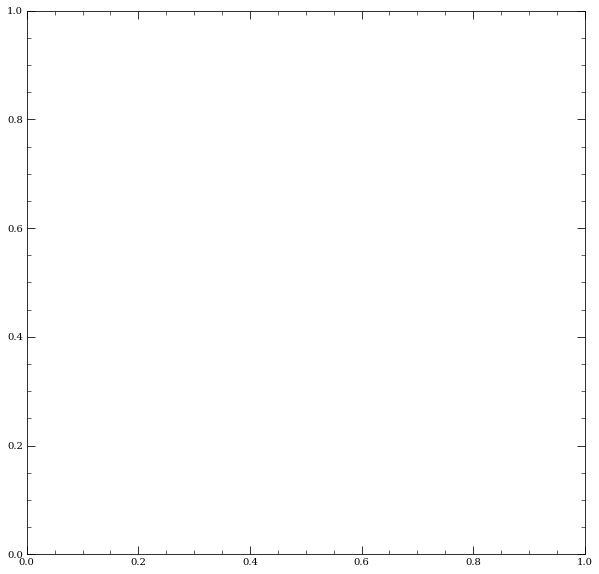

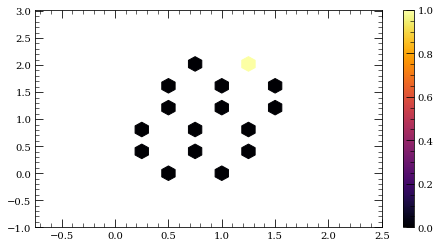

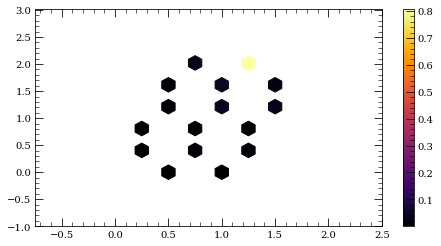

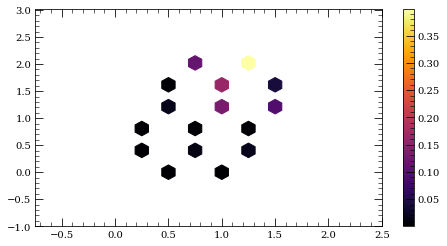

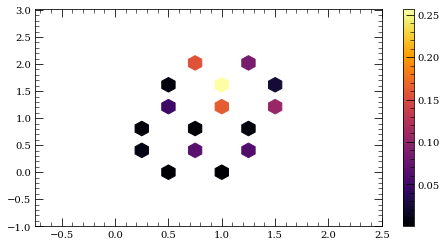

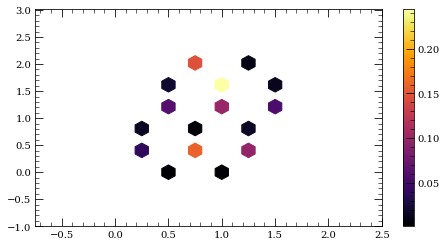

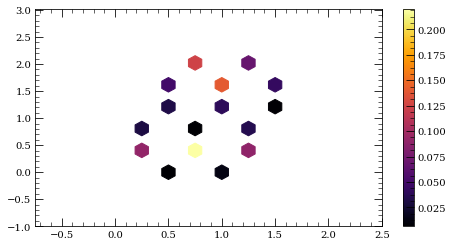

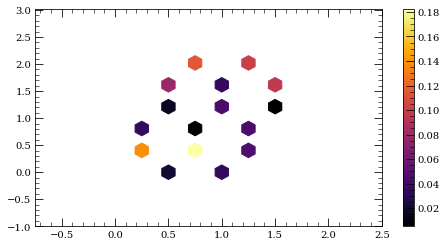

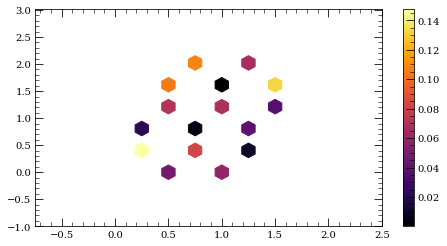

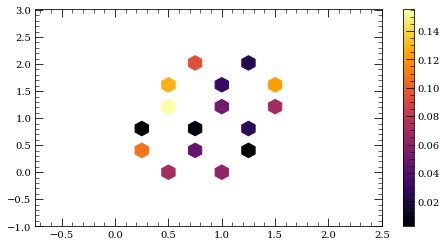

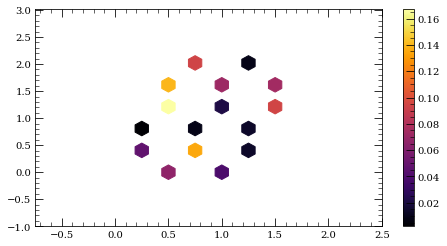

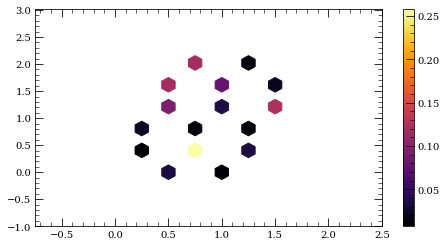

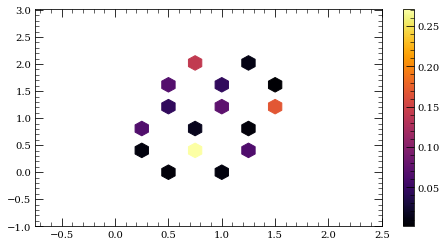

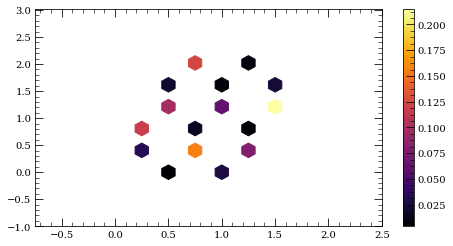

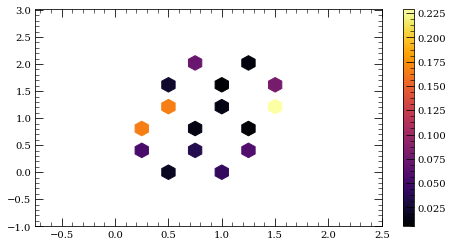

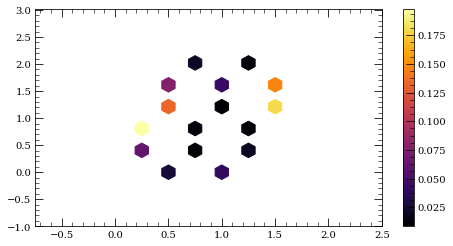

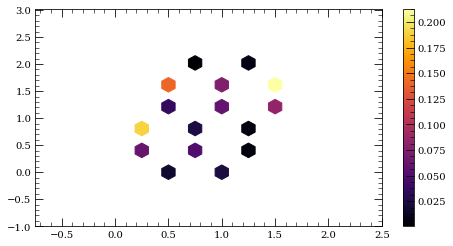

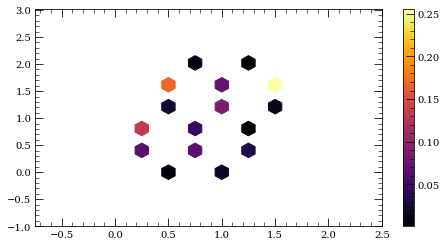

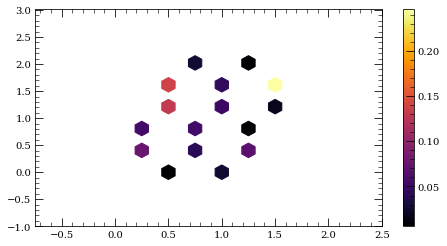

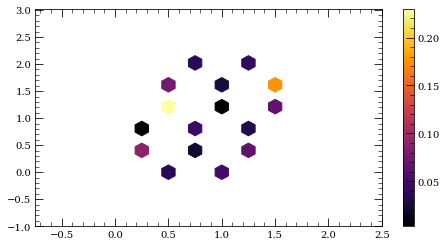

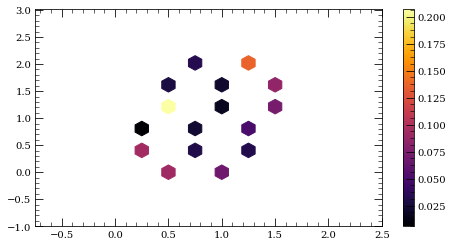

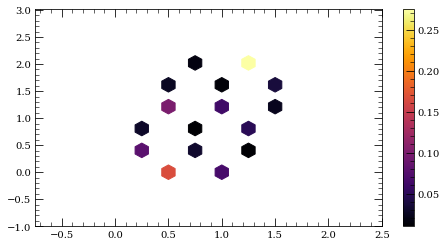

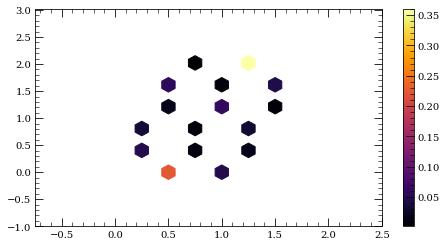

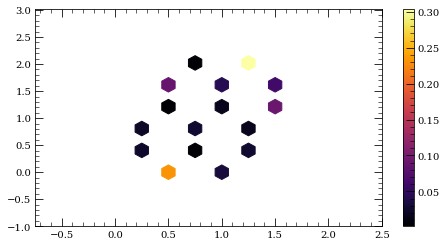

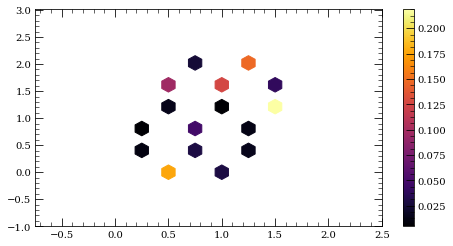

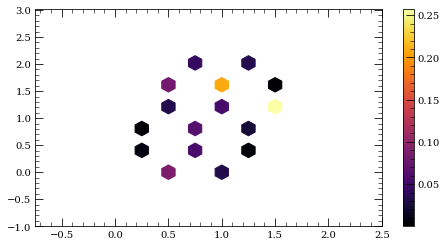

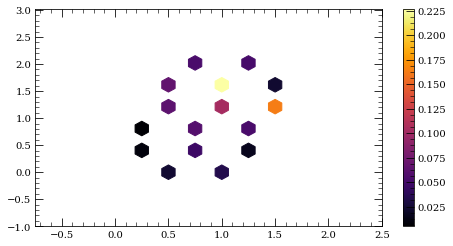

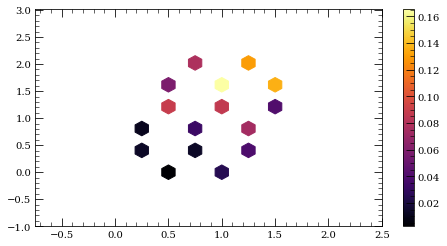

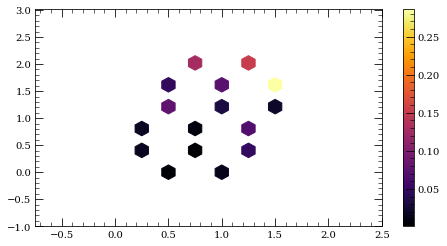

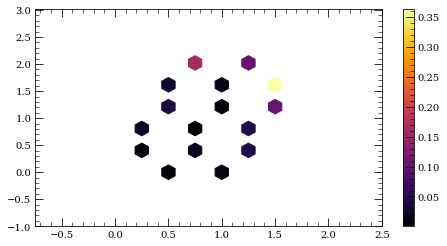

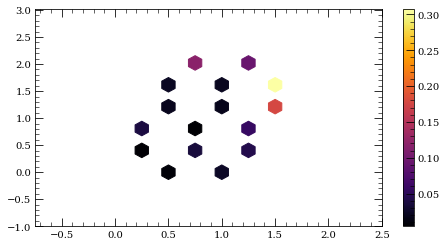

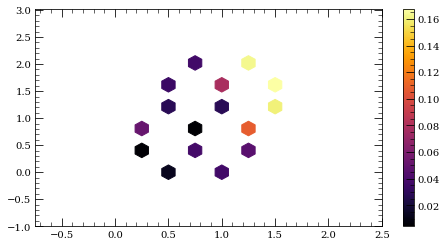

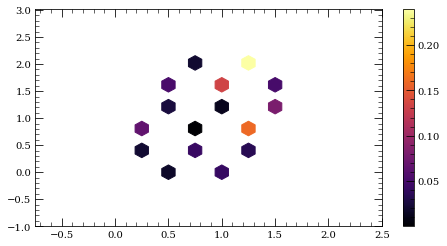

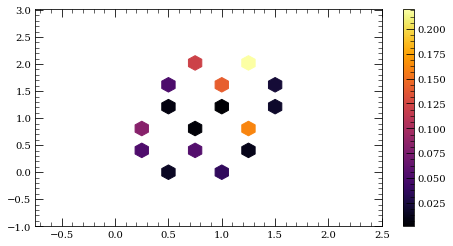

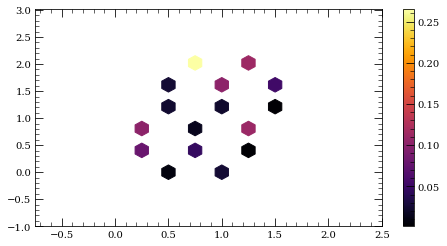

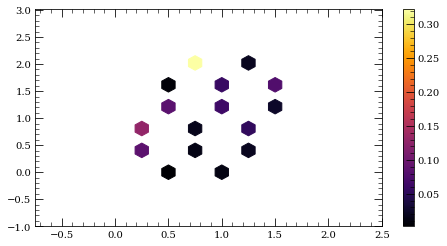

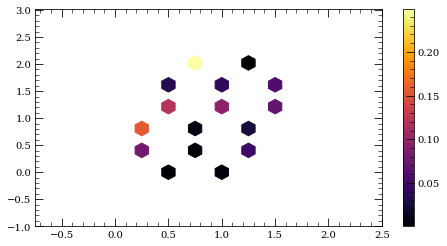

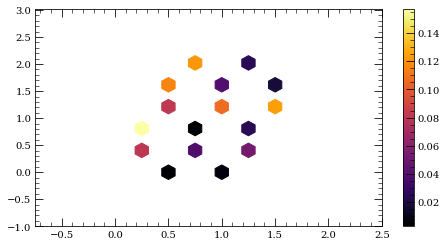

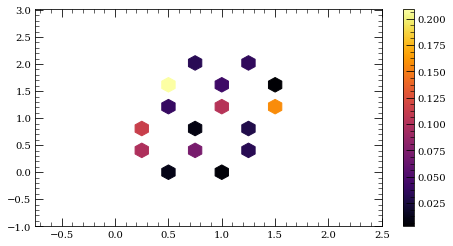

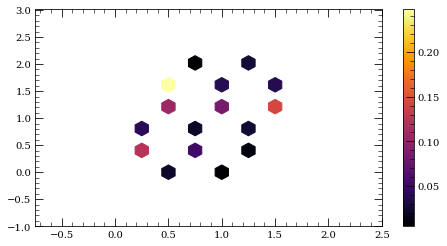

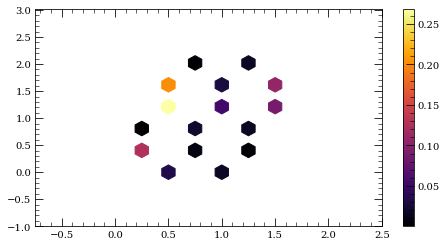

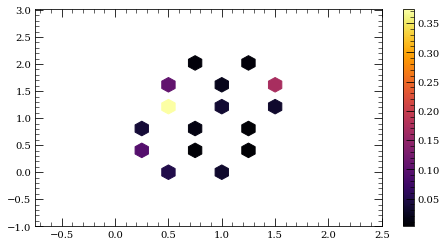

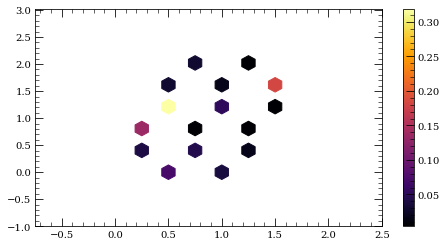

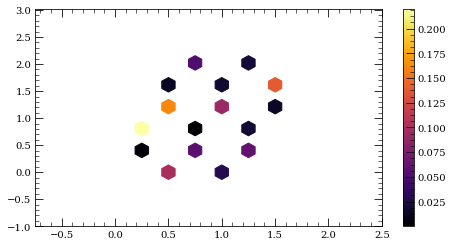

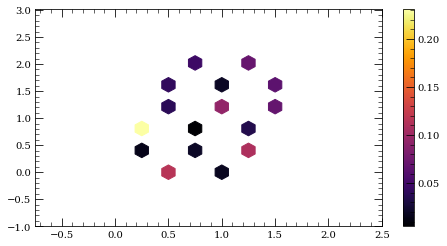

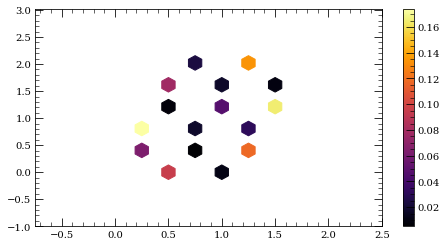

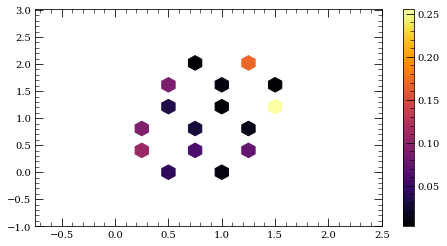

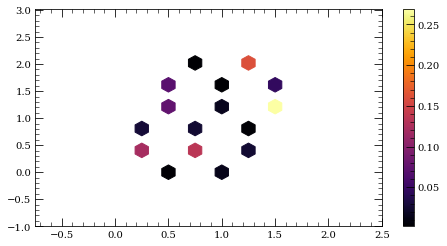

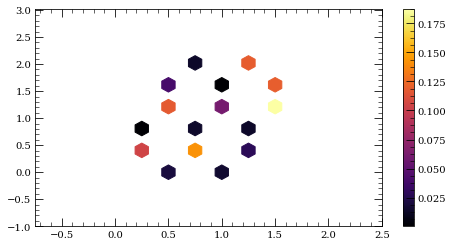

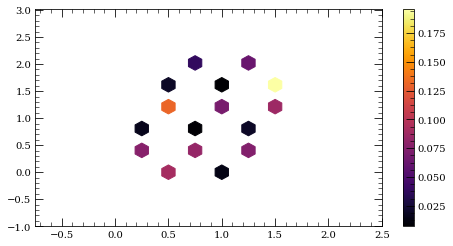

In [ ]:
atom_sets = 3        #How many coupling pairs
state_ind = 2
obs_basis = 1         #Number of excited states in observation basis
w1 = 1                #The first weight
w2 = 1               #The second weight
w3 = 1
periods = 10            #How many time periods
step = 50          #How many time steps
eVals,eVecs,ground,o_basis,result = runHamiltonian(atom_sets,state_ind,obs_basis,w1,w2,w3,periods,step)